# imports

In [41]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import mediapipe as mp

from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# file processing

In [42]:
images =[]
labels = []

dataset_path = './asl_dataset'

for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)

print(f"Loaded {len(images)} files.")

Loaded 2515 files.


In [43]:
df = pd.DataFrame({'image': images, 'label': labels})
df

image label
0     ./asl_dataset\0\hand1_0_bot_seg_1_cropped.jpeg     0
1     ./asl_dataset\0\hand1_0_bot_seg_2_cropped.jpeg     0
2     ./asl_dataset\0\hand1_0_bot_seg_3_cropped.jpeg     0
3     ./asl_dataset\0\hand1_0_bot_seg_4_cropped.jpeg     0
4     ./asl_dataset\0\hand1_0_bot_seg_5_cropped.jpeg     0
...                                              ...   ...
2510  ./asl_dataset\z\hand5_z_dif_seg_1_cropped.jpeg     z
2511  ./asl_dataset\z\hand5_z_dif_seg_2_cropped.jpeg     z
2512  ./asl_dataset\z\hand5_z_dif_seg_3_cropped.jpeg     z
2513  ./asl_dataset\z\hand5_z_dif_seg_4_cropped.jpeg     z
2514  ./asl_dataset\z\hand5_z_dif_seg_5_cropped.jpeg     z

[2515 rows x 2 columns]

In [44]:
df['label'].describe()

count     2515
unique      36
top          0
freq        70
Name: label, dtype: object

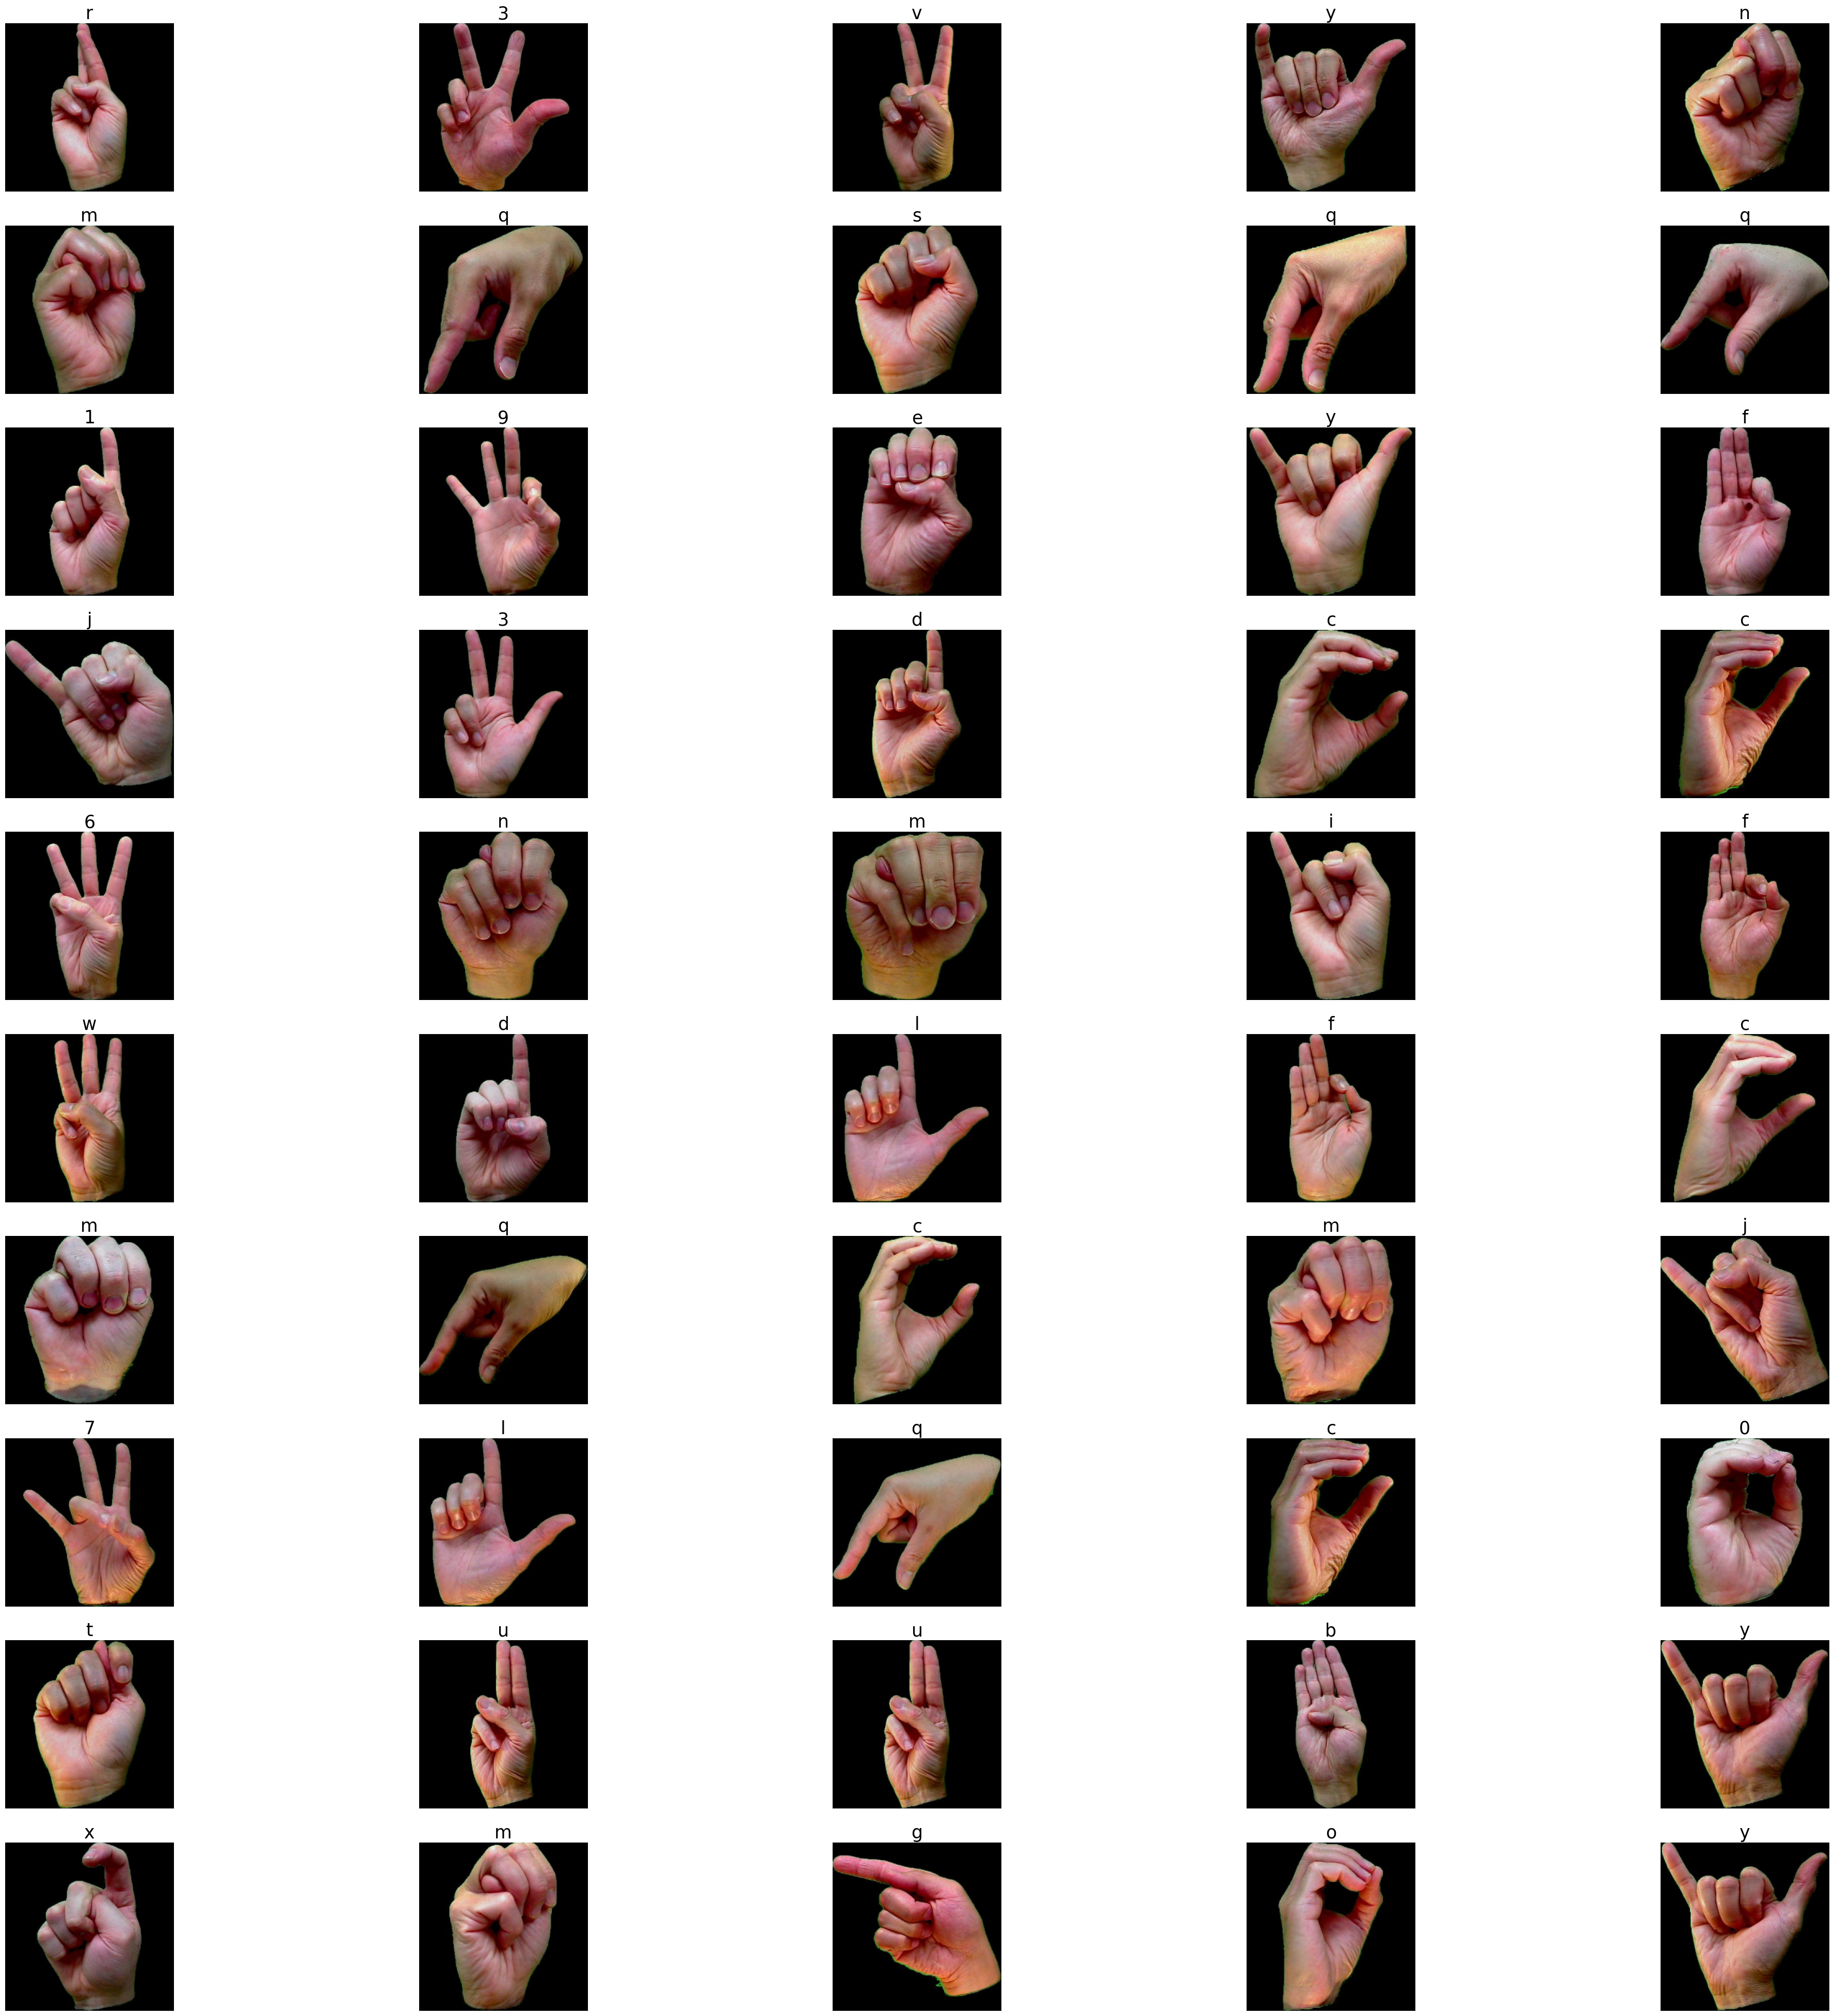

In [45]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

# Data Processing

In [46]:
def preprocess_images(image_paths):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (224, 224))  # Resize to 224x224
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = img / 255.0  # Normalize pixel values to [0, 1]
        images.append(img)
    return np.array(images)

# Spliting Data



In [47]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [48]:
train_size = int(0.7 * len(df))  # 70% for training
val_size = int(0.15 * len(df))   # 15% for validation
test_size = len(df) - train_size - val_size  # 15% for testing

In [49]:
train_df = df[:train_size]
val_df = df[train_size:train_size + val_size]
test_df = df[train_size + val_size:]

In [50]:
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 1760
Validation set size: 377
Test set size: 378


In [51]:
print("Train set label distribution:")
print(train_df['label'].value_counts())

print("Validation set label distribution:")
print(val_df['label'].value_counts())

print("Test set label distribution:")
print(test_df['label'].value_counts())

Train set label distribution:
label
4    61
8    55
3    55
q    54
s    52
k    52
6    52
v    52
f    51
j    51
7    51
m    51
i    50
d    50
o    50
n    50
e    49
r    49
p    49
u    48
h    47
0    47
5    47
2    47
y    46
a    46
x    46
w    46
b    46
l    45
t    45
z    45
c    45
9    45
1    44
g    41
Name: count, dtype: int64
Validation set label distribution:
label
1    18
h    16
a    16
u    16
c    15
j    13
5    13
0    13
x    12
m    12
w    12
g    11
r    11
i    11
b    11
d    11
7    11
z    11
6    10
s    10
v    10
9     9
q     9
e     9
n     9
k     9
2     9
3     9
t     8
y     8
l     8
f     7
p     7
o     6
4     4
8     3
Name: count, dtype: int64
Test set label distribution:
label
g    18
l    17
9    16
y    16
p    14
2    14
z    14
o    14
b    13
f    12
x    12
w    12
t    12
8    12
e    12
n    11
5    10
c    10
r    10
0    10
k     9
d     9
i     9
1     8
7     8
6     8
a     8
v     8
s     8
m     7
q     7
h     7
3   

# Model

## Prepare Data

In [52]:
# Separate image paths (X) and labels (y)
X_train = train_df['image'].values
y_train = train_df['label'].values

X_val = val_df['image'].values
y_val = val_df['label'].values

X_test = test_df['image'].values
y_test = test_df['label'].values

In [53]:
X_train_processed = preprocess_images(X_train)
X_val_processed = preprocess_images(X_val)
X_test_processed = preprocess_images(X_test)

In [54]:
# one-hot encoding
lb = LabelBinarizer()
y_train_encoded = lb.fit_transform(y_train)
y_val_encoded = lb.transform(y_val)
y_test_encoded = lb.transform(y_test)

In [55]:
# X- (num_samples, height, width, channels-RGB)
# y- (num_samples, num_classes-labels)
print(f"X_train shape: {X_train_processed.shape}")
print(f"y_train shape: {y_train_encoded.shape}")
print(f"X_val shape: {X_val_processed.shape}")
print(f"y_val shape: {y_val_encoded.shape}")
print(f"X_test shape: {X_test_processed.shape}")
print(f"y_test shape: {y_test_encoded.shape}")

X_train shape: (1760, 224, 224, 3)
y_train shape: (1760, 36)
X_val shape: (377, 224, 224, 3)
y_val shape: (377, 36)
X_test shape: (378, 224, 224, 3)
y_test shape: (378, 36)


## MediaPipe Hands

In [56]:
# Initialize MediaPipe Hands for landmark extraction
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.5)